In [1]:
import pyroomacoustics as pra

import os
from tqdm import tqdm

import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader

from einops import rearrange

from src.dataset import SignalDataset, TRUNetDataset
from src.loss import loss_tot
from models.model1d_stream_med_1dphm import TRUNet 

from IPython.display import Audio

import soundfile as sf
import yaml

from NISQA_s.src.core.model_torch import model_init
from NISQA_s.src.utils.process_utils import process # process_
from NISQA_s.src.utils.train_utils import yamlparser

from NISQA.nisqa.NISQA_lib import NISQA_DIM

import matplotlib.pyplot as plt

In [2]:
DATA_DIR = os.path.join("..", "data", "data_thchs30")
TRAIN_DIR = os.path.join(DATA_DIR, "train_1")
TEST_DIR = os.path.join(DATA_DIR, "train_1")
RIR_DIR = os.path.join("..", "data", "RIRs_1")
NOISE_DIR = os.path.join("..", "data", "test-noise", "noise", "white")
CHKP_DIR = os.path.join("..", "checkpoints")

In [3]:
N_FFTS = 512
HOP_LENGTH = 256

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"It's {DEVICE} time!!!")

It's cuda time!!!


In [4]:
train_dataset = TRUNetDataset(TRAIN_DIR, sr=16_000, noise_dir=None, rir_dir=RIR_DIR, snr=10, return_noise=False, return_rir=True)
test_dataset = TRUNetDataset(TEST_DIR, sr=16_000, noise_dir=None, snr=10, rir_dir=RIR_DIR, return_noise=False, return_rir=True)

In [5]:
state_d = torch.load(os.path.join(CHKP_DIR, "tru-net_chkp", "fix_model#48.pt"), weights_only=False)

model = TRUNet()
model.load_state_dict(state_d["model_state_dict"])

<All keys matched successfully>

In [6]:
# state_d["plots"]['val loss']

In [7]:
def vorbis_window(winlen, device="cuda"):
    sq = torch.sin(torch.pi/2*(torch.sin(torch.pi/winlen*(torch.arange(winlen)-0.5))**2)).float()
    return sq

window = vorbis_window(512)

### Evaluation

In [8]:
input_sig, gt, gt_noise, gt_rir = train_dataset[0]

In [9]:
spec = torch.stft(
            input_sig,
            n_fft=N_FFTS,
            hop_length=HOP_LENGTH,
            # onesided=True,
            win_length=512,
            window=window,
            return_complex=True,
            normalized=True,
            center=True
        ) 

In [10]:
model.eval()

fgru_hidden_size = 64
tgru_hidden_size = 128

h_f = torch.randn(2, spec.shape[0] * spec.shape[-1], fgru_hidden_size, )
h_t = torch.randn(1, 16, tgru_hidden_size, )
output, noise, rir, _, _ = model(spec.abs(), spec.real, spec.imag, h_f, h_t)
output = torch.polar(torch.abs(output), spec.angle())
# signal = signal * spec

In [11]:
out_wave = torch.istft(output, n_fft=N_FFTS, hop_length=HOP_LENGTH, win_length=512,
                       window=window,
                       return_complex=False,
                       normalized=True,
                       center=True)# [..., 20:-20]

out_wave, _ = SignalDataset.normalize_audio(out_wave)
# out_wave = 2 * (out_wave - out_wave.min()) / (out_wave.max() - out_wave.min() + 1e-8) - 1

# out_noise = torch.istft(noise * spec , n_fft=N_FFTS, hop_length=HOP_LENGTH, win_length=512,
#                        window=window,
#                        return_complex=False,
#                        normalized=True,
#                        center=True)
# out_noise, _ = SignalDataset.normalize_audio(out_noise)
# # out_noise = 2 * (out_noise - out_noise.min()) / (out_noise.max() - out_noise.min() + 1e-8) - 1
# 
# out_rir = torch.istft(rir * spec , n_fft=N_FFTS, hop_length=HOP_LENGTH, win_length=512,
#                        window=window,
#                        return_complex=False,
#                        normalized=True,
#                        center=True)
# out_rir, _ = SignalDataset.normalize_audio(out_rir)
# out_rir = 2 * (out_rir - out_rir.min()) / (out_rir.max() - out_rir.min() + 1e-8) - 1

In [12]:
out_wave.min()

tensor(-1., grad_fn=<MinBackward1>)

In [13]:
Audio(gt.numpy(), rate=16_000)

In [14]:
Audio(input_sig.numpy(), rate=16_000)

In [15]:
Audio(out_wave.detach().numpy(), rate=16_000)

In [16]:
# from scipy.io.wavfile import write
# 
# # audio = sd.rec(int(duration * samplerate), samplerate=16_000, channels=1)
# # sd.wait()  # дождаться окончания записи
# 
# write('input_sig.wav', 16_000, input_sig.detach().numpy()[0])
# write('gt.wav', 16_000, gt.detach().numpy()[0])
# write('output.wav', 16_000, out_wave.detach().numpy()[0])

In [18]:
max_len = min(out_wave.shape[-1], gt.shape[-1])

### Loss(output, gt)

In [19]:
loss_tot(out_wave[..., :max_len], gt[..., :max_len])#, out_noise[..., :max_len], gt_noise[..., :max_len], out_rir[..., :max_len], gt_rir[..., :max_len])

tensor(0.1528, grad_fn=<AddBackward0>)

### Loss(input, gt)

In [21]:
loss_tot(input_sig[..., :max_len], gt[..., :max_len])# , out_noise[..., :max_len], out_noise[..., :max_len], out_rir[..., :max_len], out_rir[..., :max_len])

tensor(0.6076)

### Loss(output, input)

In [22]:
loss_tot(out_wave[..., :max_len], input_sig[..., :max_len])

tensor(-0.3504, grad_fn=<AddBackward0>)

### Waveform plots

In [24]:
def plot_waveform(waveform, sample_rate):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sample_rate

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].plot(time_axis, waveform[c], linewidth=1)
        axes[c].grid(True)
        if num_channels > 1:
            axes[c].set_ylabel(f"Channel {c+1}")
    figure.suptitle("waveform")

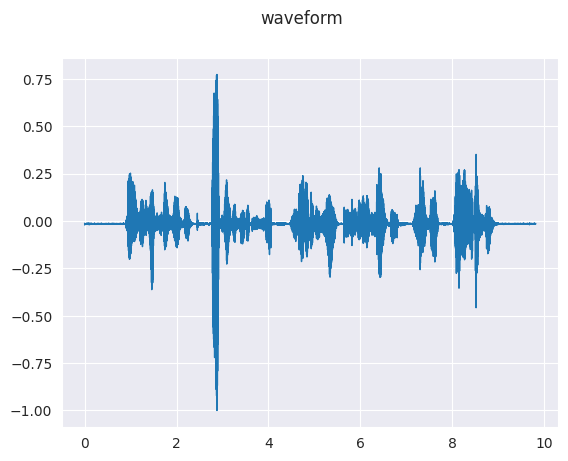

In [25]:
plot_waveform(gt.detach(), 16_000)

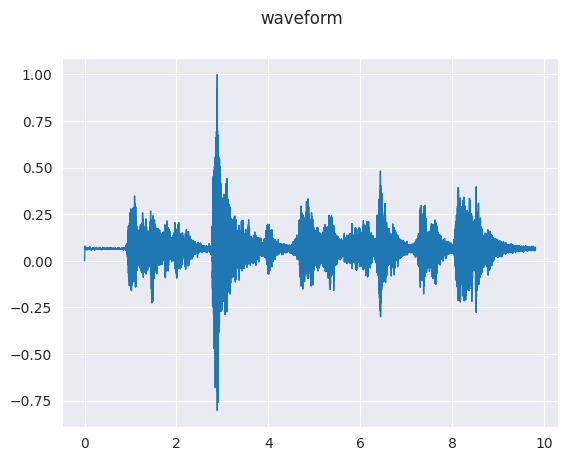

In [26]:
plot_waveform(input_sig.detach(), 16_000)

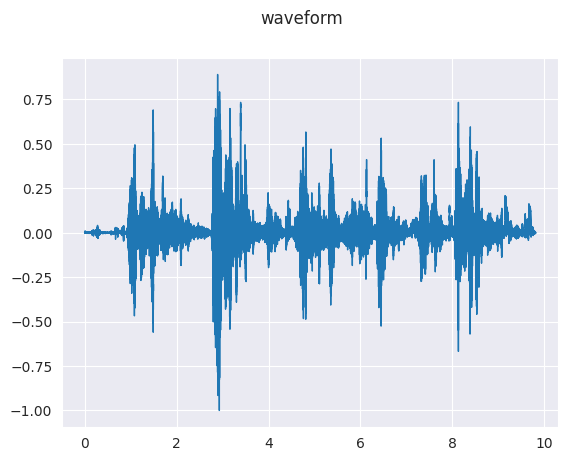

In [27]:
plot_waveform(out_wave.detach(), 16_000)